# Exploratory Data Analysis

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load data
data_path = Path("../data/raw/movies.csv")
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")


Dataset shape: (9837, 9)


### Casting datatypes and removing unnecessary data

In [104]:
df.columns = [col.lower() for col in df.columns]
df.dtypes

release_date          object
title                 object
overview              object
popularity           float64
vote_count            object
vote_average          object
original_language     object
genre                 object
poster_url            object
dtype: object

In [105]:
df.head()

,release_date,title,overview,popularity,vote_count,vote_average,original_language,genre,poster_url
0,2021-12-15,Spider-Man: No Way Home,Peter Parker is unmasked and no longer able to...,5083.954,8940,8.3,en,"Action, Adventure, Science Fiction",https://image.tmdb.org/t/p/original/1g0dhYtq4i...
1,2022-03-01,The Batman,"In his second year of fighting crime, Batman u...",3827.658,1151,8.1,en,"Crime, Mystery, Thriller",https://image.tmdb.org/t/p/original/74xTEgt7R3...
2,2022-02-25,No Exit,Stranded at a rest stop in the mountains durin...,2618.087,122,6.3,en,Thriller,https://image.tmdb.org/t/p/original/vDHsLnOWKl...
3,2021-11-24,Encanto,"The tale of an extraordinary family, the Madri...",2402.201,5076,7.7,en,"Animation, Comedy, Family, Fantasy",https://image.tmdb.org/t/p/original/4j0PNHkMr5...
4,2021-12-22,The King's Man,As a collection of history's worst tyrants and...,1895.511,1793,7.0,en,"Action, Adventure, Thriller, War",https://image.tmdb.org/t/p/original/aq4Pwv5Xeu...


In [106]:
# Drop unnecessary columns (to eliminate possible data leakage)
df = df.drop(columns=['popularity', 'vote_count', 'poster_url'])

In [107]:
### Convert to float
df['vote_average'] = df['vote_average'].apply(pd.to_numeric, errors='coerce', downcast='float')
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df.dtypes

release_date         datetime64[ns]
title                        object
overview                     object
vote_average                float64
original_language            object
genre                        object
dtype: object

In [108]:
# Missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})
missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

,Missing Count,Missing %
vote_average,11,0.111823
genre,11,0.111823
release_date,10,0.101657
original_language,10,0.101657
title,9,0.091491
overview,9,0.091491


Since the number of rows with missing rows is minimal, such data will be deleted.

In [109]:
df.dropna(inplace=True)

In [110]:
df.isnull().sum()

release_date         0
title                0
overview             0
vote_average         0
original_language    0
genre                0
dtype: int64

In [111]:
df.shape

(9826, 6)

### Examining the target - Vote Average

In [112]:
# Basic statistics
df.describe().round(2)

,release_date,vote_average
count,9826,9826.00
mean,2006-09-23 04:47:14.276409600,6.44
min,1902-04-17 00:00:00,0.00
25%,2000-10-17 12:00:00,5.90
50%,2011-09-12 00:00:00,6.50
75%,2017-11-22 00:00:00,7.10
max,2024-07-03 00:00:00,10.00
std,NaN,1.13


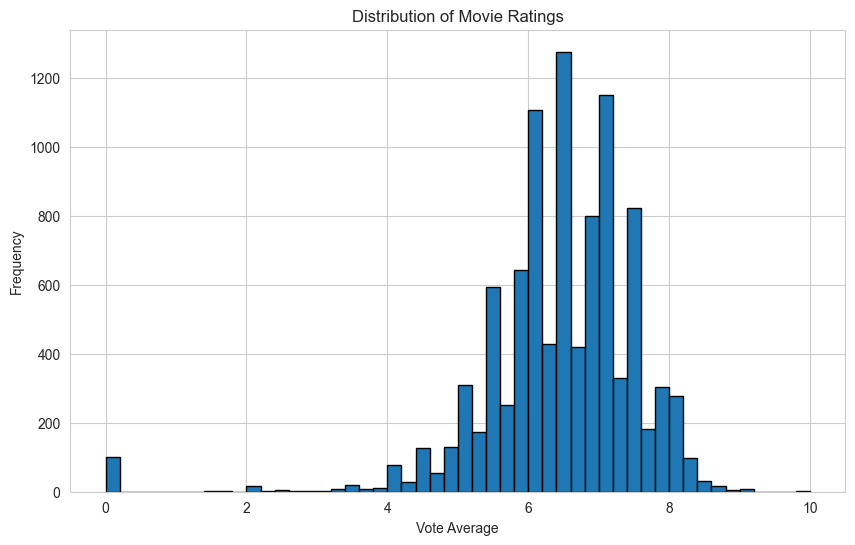

In [113]:
# Target variable distribution
plt.figure(figsize=(10, 6))
plt.hist(df['vote_average'], bins=50, edgecolor='black')
plt.xlabel('Vote Average')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Ratings')
plt.show()

In [116]:
# 0 as an average vote seems suspicious
df_zero_vote = df[df.vote_average == 0]
df_zero_vote.sort_values('release_date', ascending=False).head()

,release_date,title,overview,vote_average,original_language,genre
3333,2024-07-03,Despicable Me 4,The fourth installment of the Despicable Me fr...,0.0,en,"Animation, Family, Comedy, Adventure"
6795,2023-07-26,Ant-Man and the Wasp: Quantumania,The third film in the Marvel Studios' Ant-Man ...,0.0,en,"Adventure, Science Fiction, Comedy"
414,2023-06-23,The Flash,The Flash travels back in time to prevent the ...,0.0,en,"Action, Adventure, Science Fiction, Fantasy, D..."
1767,2023-06-07,Transformers: Rise of the Beasts,The origin story for Optimus Prime and how he ...,0.0,en,"Action, Science Fiction, Adventure"
9144,2023-05-24,The Little Mermaid,A young mermaid makes a deal with a sea witch:...,0.0,en,"Adventure, Family, Fantasy, Romance"


In [117]:
df_zero_vote.shape

(100, 6)

In [118]:
# Movies with 0 vote average are either very new or have no votes yet, so we can safely remove them
df = df[df.vote_average != 0]
df.shape

(9726, 6)

### Examining the features

In [119]:
df['genre'] = df.genre.fillna('').apply(lambda x: x.split(', '))

In [120]:
genre_counts = df["genre"].explode().value_counts()

genre_df = pd.concat([genre_counts, round(genre_counts/df.shape[0], 2)], axis=1, keys=['Genre Count', '% Movies'])
genre_df

,Genre Count,% Movies
genre,,
Drama,3715,0.38
Comedy,3006,0.31
Action,2652,0.27
Thriller,2473,0.25
Adventure,1829,0.19
Romance,1461,0.15
Horror,1457,0.15
Animation,1425,0.15
Family,1405,0.14


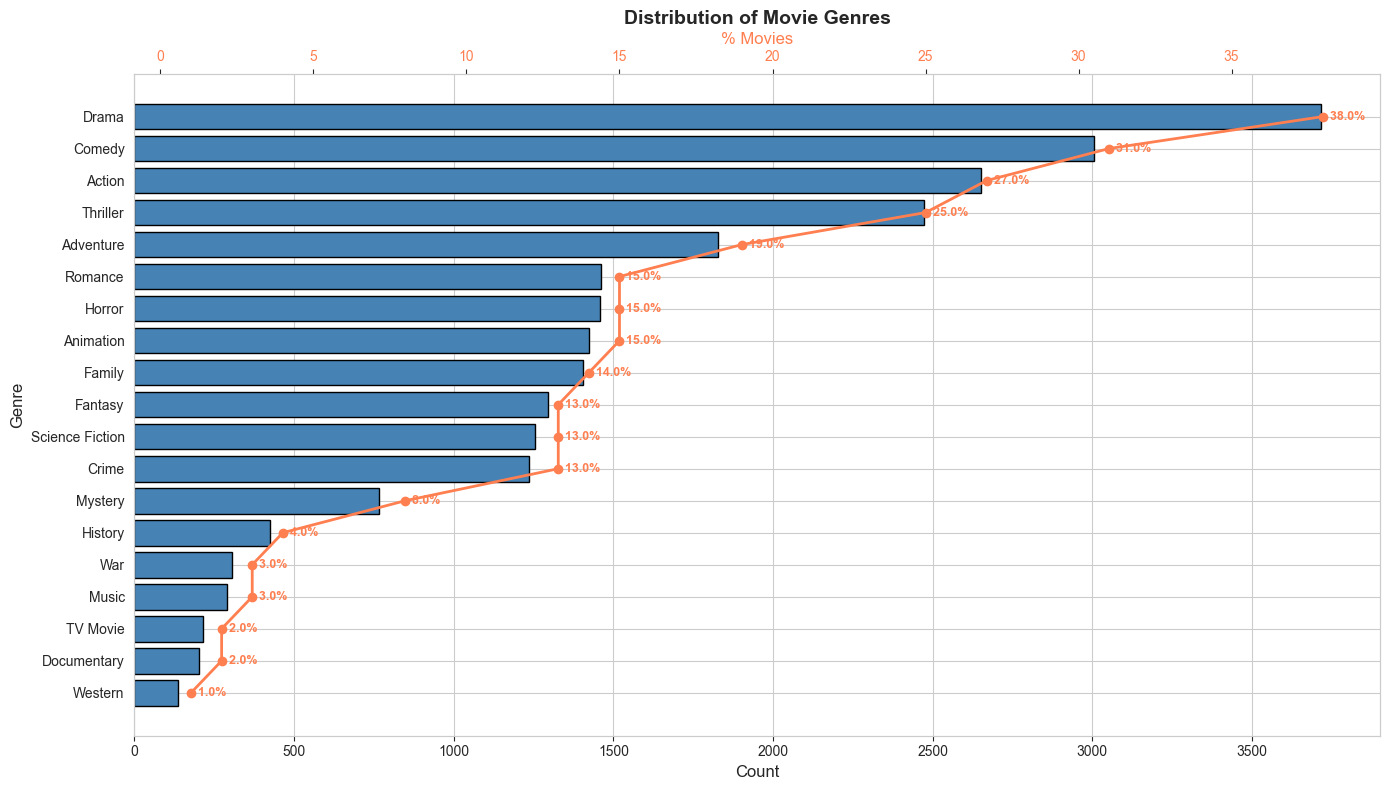

In [121]:
# Genre distribution chart
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar chart for genre count
ax1.barh(range(len(genre_counts)), genre_counts.values, color='steelblue', edgecolor='black')
ax1.set_xlabel('Count', fontsize=12)
ax1.set_ylabel('Genre', fontsize=12)
ax1.set_yticks(range(len(genre_counts)))
ax1.set_yticklabels(genre_counts.index)
ax1.invert_yaxis()  # Show highest count at top

# Line chart for % movies on secondary axis
ax2 = ax1.twiny()  # Create a second x-axis on top
pct_values = genre_df['% Movies'] * 100
ax2.plot(pct_values.values, range(len(pct_values)), 'o-', color='coral', linewidth=2, markersize=6, label='% Movies')
ax2.set_xlabel('% Movies', fontsize=12, color='coral')
ax2.tick_params(axis='x', labelcolor='coral')
ax2.grid(False)  # Remove vertical gridlines for percentage axis

# Add percentage value labels on the line markers
for i, (genre, pct) in enumerate(zip(genre_counts.index, pct_values.values)):
    ax2.text(pct, i, f'  {pct:.1f}%', va='center', fontsize=9, color='coral', fontweight='bold')

plt.title('Distribution of Movie Genres', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [144]:
# Original language distribution
pd.concat([df.original_language.value_counts(), df.original_language.value_counts(normalize=True)], axis=1, keys=['Count', 'Percentage']).head(10)

,Count,Percentage
original_language,,
en,7507,0.771849
ja,643,0.066111
es,333,0.034238
fr,280,0.028789
ko,165,0.016965
zh,129,0.013263
it,123,0.012647
cn,108,0.011104
ru,83,0.008534


In [145]:
df.original_language.nunique()

42

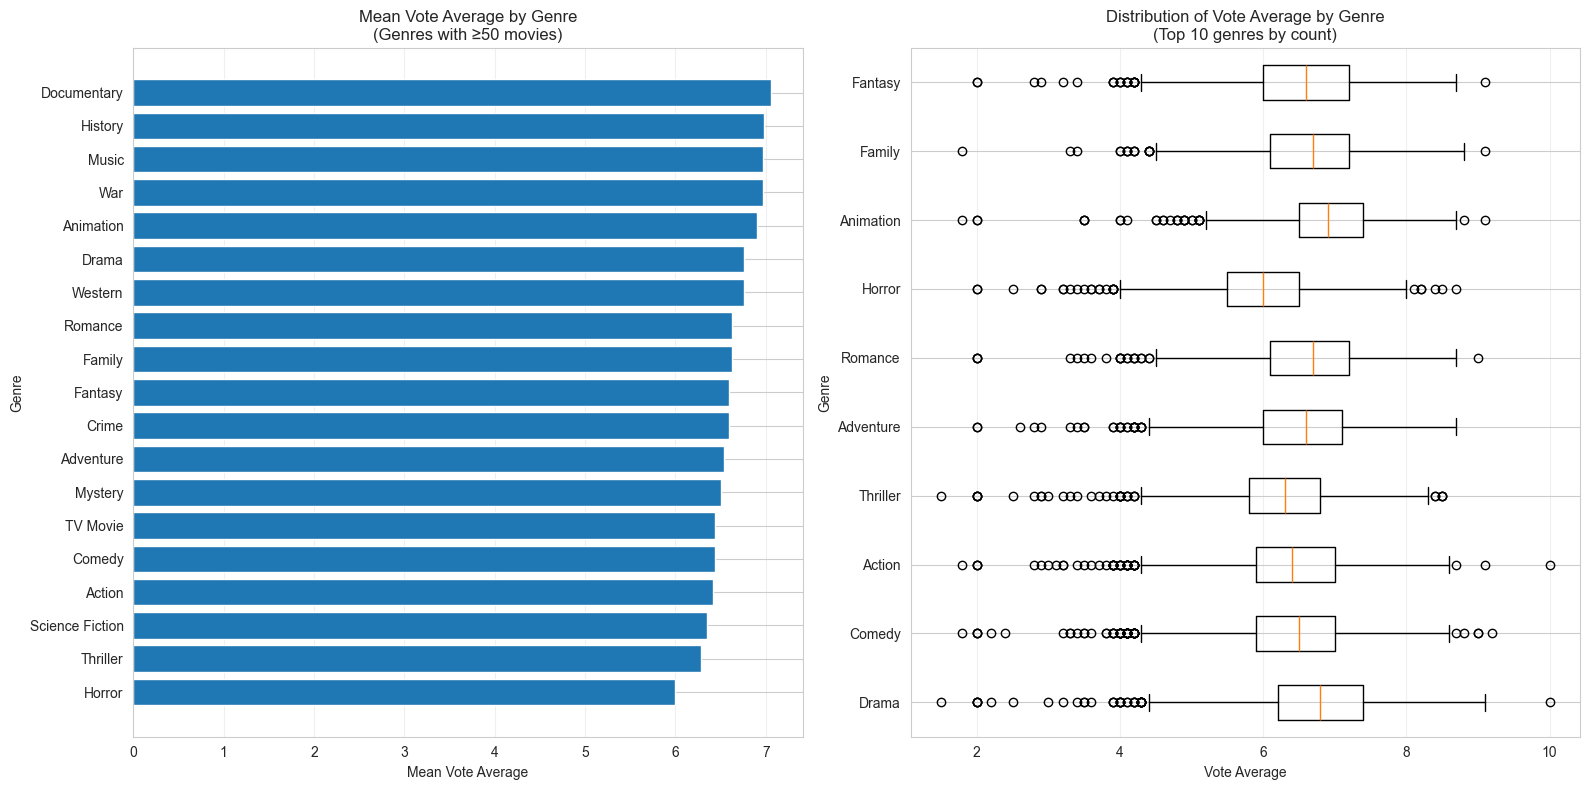

Top 10 genres by mean vote average (min 50 movies):
             mean  median  count
genre                           
Documentary  7.06     7.2    203
History      6.98     7.0    426
Music        6.97     7.0    291
War          6.97     7.0    307
Animation    6.91     6.9   1425
Drama        6.76     6.8   3715
Western      6.75     6.9    137
Romance      6.63     6.7   1461
Family       6.62     6.7   1405
Fantasy      6.59     6.6   1295


In [ ]:
# Target variable by genre
g = df.explode("genre")

genre_stats = (
    g.groupby("genre")
     .agg(
         mean=("vote_average", "mean"),
         median=("vote_average", "median"),
         count=("vote_average", "count")
     )
     .sort_values("mean", ascending=False)
)
genre_stats_filt = genre_stats.query("count >= 50")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# --- Mean vote average per genre ---
ax1.barh(
    genre_stats_filt.index,
    genre_stats_filt["mean"]
)
ax1.invert_yaxis()
ax1.set(
    xlabel="Mean Vote Average",
    ylabel="Genre",
    title="Mean Vote Average by Genre\n(Genres with ≥50 movies)"
)
ax1.grid(axis="x", alpha=0.3)

# --- Box plot for top 10 genres by count ---
top_genres = (
    genre_stats
    .sort_values("count", ascending=False)
    .head(10)
    .index
)

box_data = [
    g.loc[g["genre"] == genre, "vote_average"]
    for genre in top_genres
]

ax2.boxplot(box_data, tick_labels=top_genres, vert=False)
ax2.set(
    xlabel="Vote Average",
    ylabel="Genre",
    title="Distribution of Vote Average by Genre\n(Top 10 genres by count)"
)
ax2.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.show()


print("Top 10 genres by mean vote average (min 50 movies):")
print(genre_stats_filt.head(10).round(2))

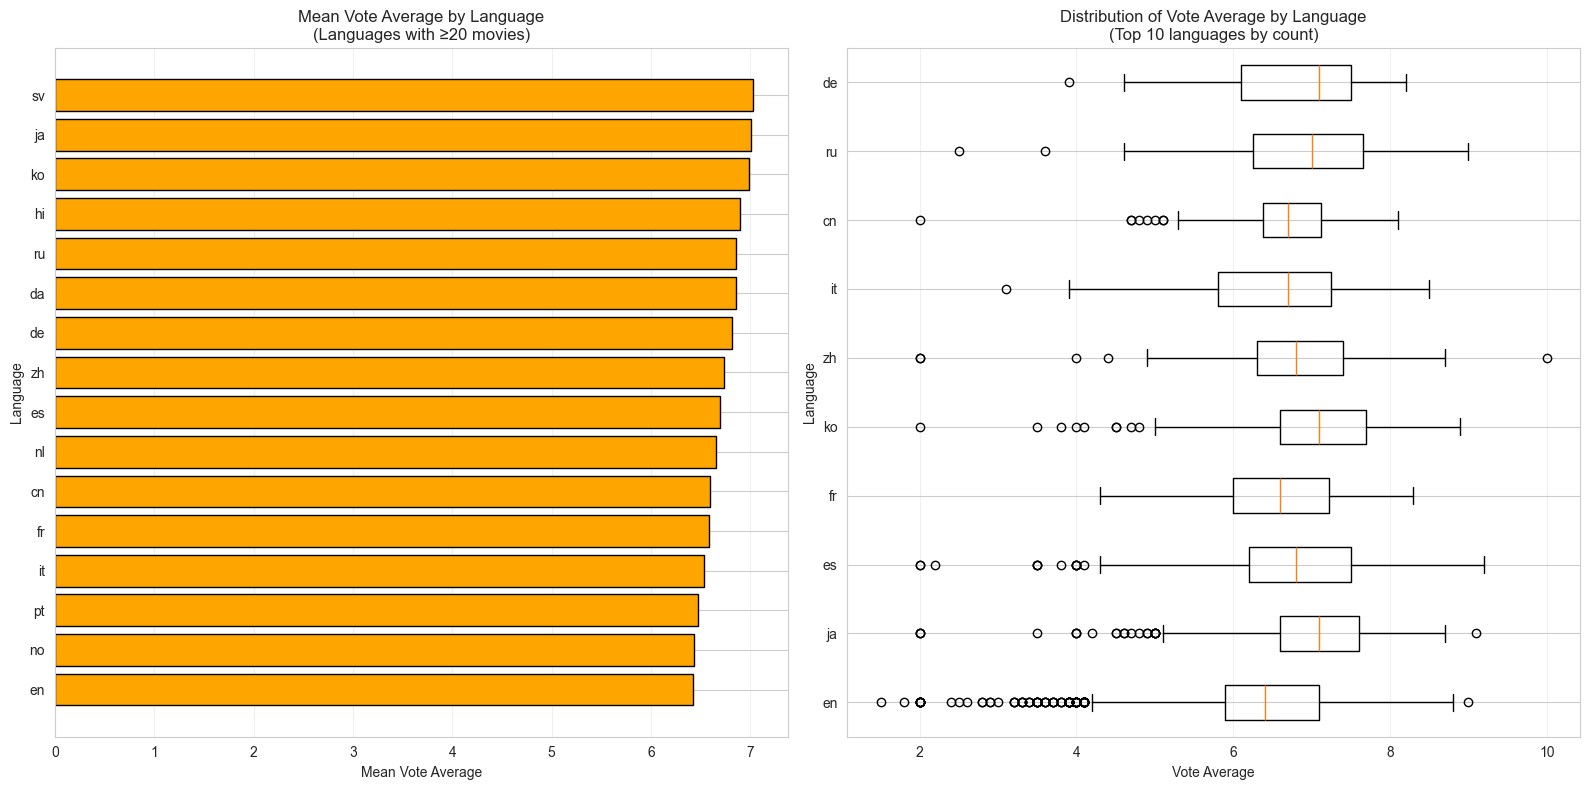

Top 10 languages by mean vote average (min 20 movies):
                   mean  median  count
original_language                     
sv                 7.02    7.00     23
ja                 7.00    7.10    643
ko                 6.99    7.10    165
hi                 6.89    7.00     25
ru                 6.86    7.00     83
da                 6.85    7.00     27
de                 6.81    7.10     81
zh                 6.74    6.80    129
es                 6.69    6.80    333
nl                 6.65    6.55     20


In [152]:
### Target variable (vote_average) by Language
language_stats = (
    df.groupby("original_language")
      .agg(
          mean=("vote_average", "mean"),
          median=("vote_average", "median"),
          count=("vote_average", "count")
      )
      .sort_values("mean", ascending=False)
)

# Filter languages with enough movies
language_stats_filt = language_stats.query("count >= 20")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# --- Mean vote average per language ---
ax1.barh(
    language_stats_filt.index,
    language_stats_filt["mean"],
    color="orange",
    edgecolor="black"
)
ax1.invert_yaxis()
ax1.set(
    xlabel="Mean Vote Average",
    ylabel="Language",
    title="Mean Vote Average by Language\n(Languages with ≥20 movies)"
)
ax1.grid(axis="x", alpha=0.3)

# --- Box plot for top 10 languages by count ---
top_languages = (
    language_stats
    .sort_values("count", ascending=False)
    .head(10)
    .index
)

box_data = [
    df.loc[df["original_language"] == lang, "vote_average"]
    for lang in top_languages
]

ax2.boxplot(box_data, tick_labels=top_languages, vert=False)
ax2.set(
    xlabel="Vote Average",
    ylabel="Language",
    title="Distribution of Vote Average by Language\n(Top 10 languages by count)"
)
ax2.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.show()


print("Top 10 languages by mean vote average (min 20 movies):")
print(language_stats_filt.head(10).round(2))